In [1]:
!pip install captum torch torchvision pandas pillow matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.1 MB/s eta 0:00:00a 0:00:01


Step: 16, Epoch [0/1], D_loss: 2.7796, G_loss: 1.4864
Step: 16, Epoch [0/1], D_loss: 2.2428, G_loss: 2.5186
Step: 16, Epoch [0/1], D_loss: 1.6354, G_loss: 3.5753
Step: 16, Epoch [0/1], D_loss: 1.9395, G_loss: 2.8837
Step: 16, Epoch [0/1], D_loss: 1.6179, G_loss: 3.4177
Step: 16, Epoch [0/1], D_loss: 1.4549, G_loss: 3.9960
Step: 16, Epoch [0/1], D_loss: 1.3684, G_loss: 4.0418
Step: 16, Epoch [0/1], D_loss: 1.0859, G_loss: 4.8397
Step: 16, Epoch [0/1], D_loss: 1.1179, G_loss: 5.2223
Step: 16, Epoch [0/1], D_loss: 0.8485, G_loss: 5.7293
Step: 16, Epoch [0/1], D_loss: 0.8518, G_loss: 6.2565
Step: 16, Epoch [0/1], D_loss: 0.5953, G_loss: 6.8691
Step: 16, Epoch [0/1], D_loss: 0.5137, G_loss: 7.5123
Step: 16, Epoch [0/1], D_loss: 0.4601, G_loss: 7.5863
Step: 16, Epoch [0/1], D_loss: 0.4298, G_loss: 7.9885
Step: 16, Epoch [0/1], D_loss: 0.3997, G_loss: 8.1506
Step: 16, Epoch [0/1], D_loss: 0.3555, G_loss: 8.2506
Step: 16, Epoch [0/1], D_loss: 0.2846, G_loss: 8.8678
Step: 16, Epoch [0/1], D_los

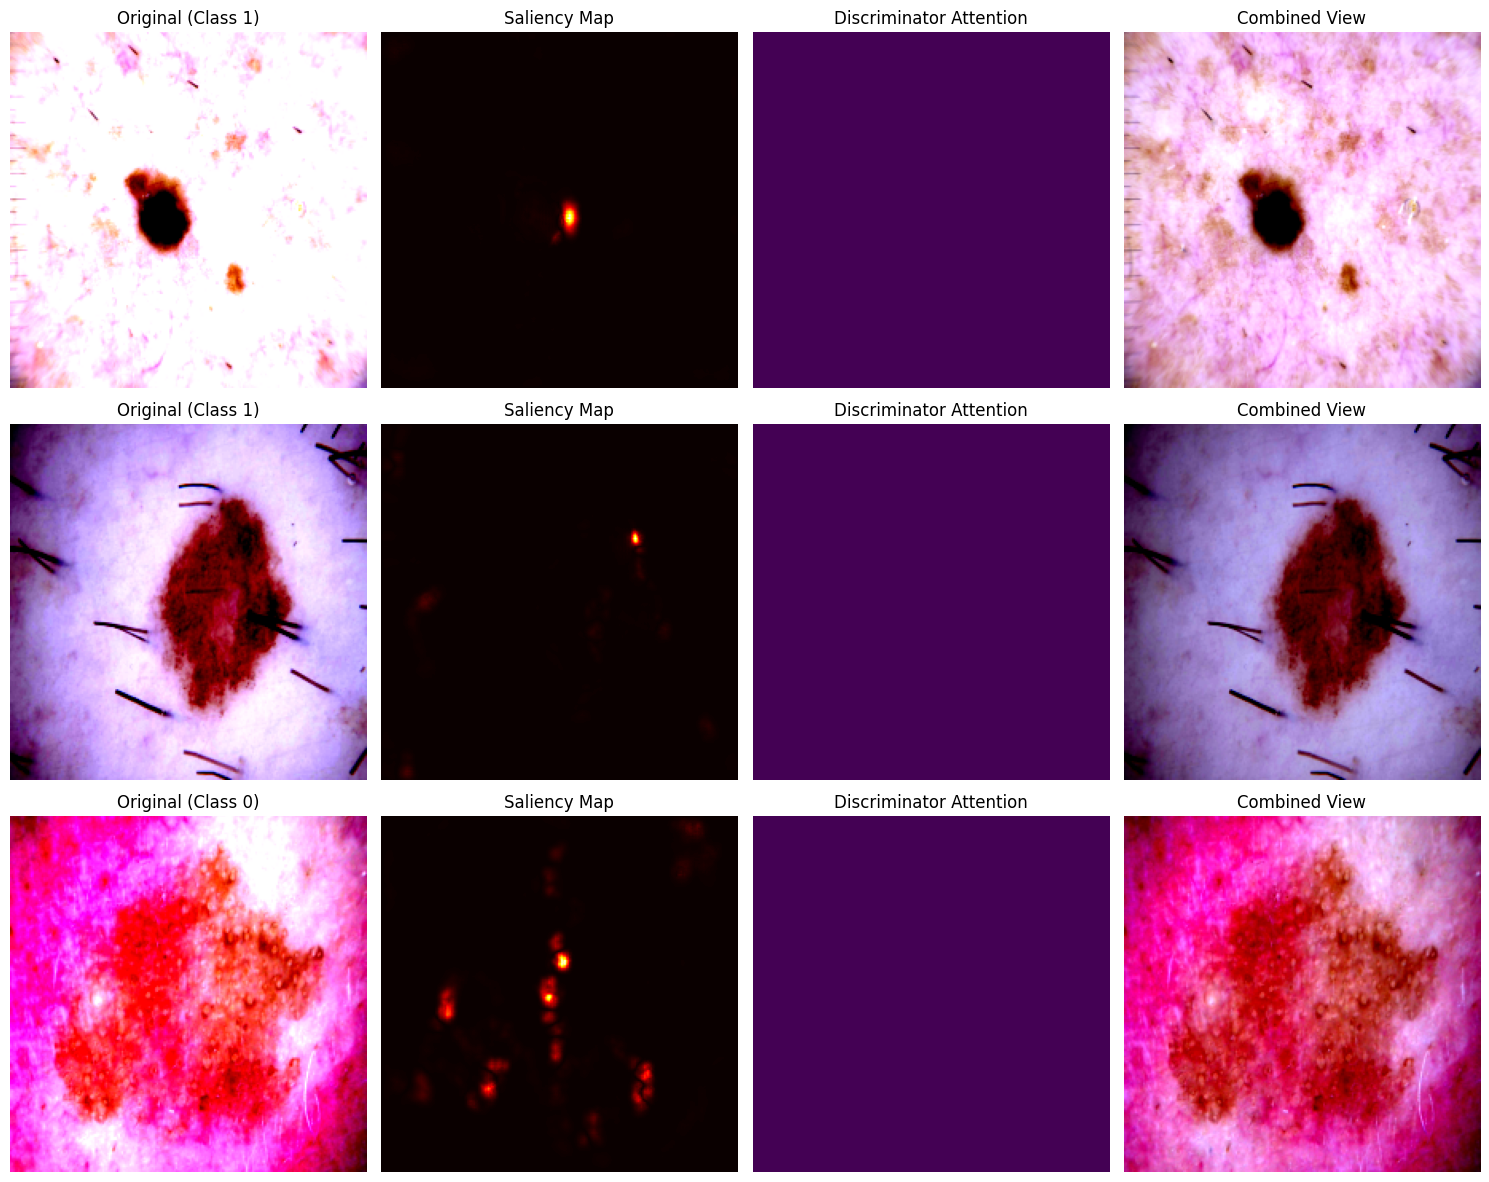

Mean accuracy over 2000 episodes: 0.1818
Few-shot learning visualization:


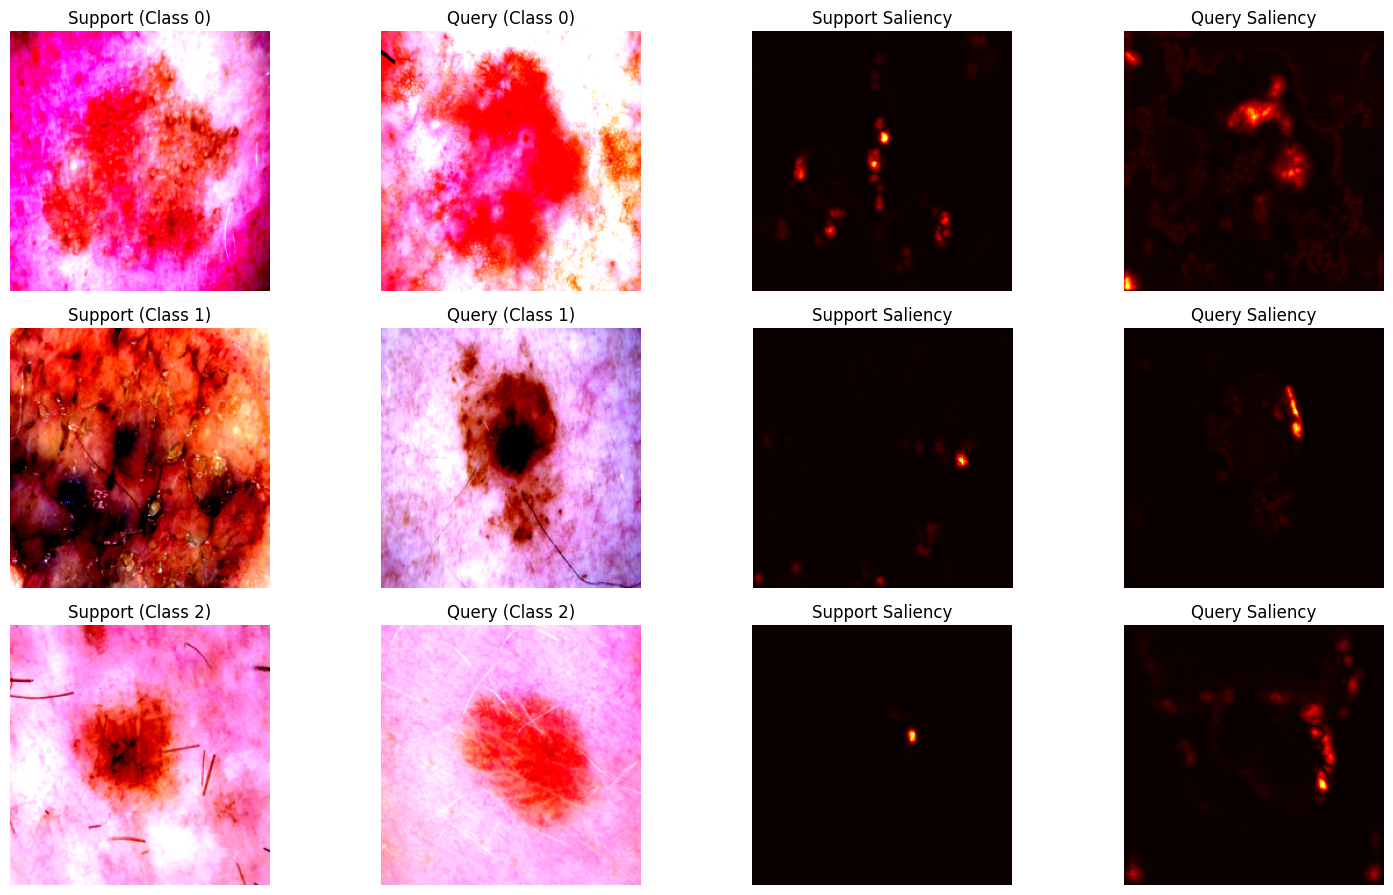

In [4]:
# Imports
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import Saliency
import time
from sklearn.metrics import accuracy_score
# Dataset Class
class HAM10000Dataset(Dataset):
    def __init__(self, csv_file, img_dirs, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dirs = img_dirs
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['image_id'] + '.jpg'
        for img_dir in self.img_dirs:
            img_path = os.path.join(img_dir, img_name)
            if os.path.exists(img_path):
                image = Image.open(img_path).convert('RGB')
                break
        label = self.data.iloc[idx]['dx']
        label_map = {label: idx for idx, label in enumerate(self.data['dx'].unique())}
        label = label_map[label]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data paths
metadata_path = "../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
image_dirs = [
    "../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1",
    "../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"
]
    
# Load metadata
metadata = pd.read_csv(metadata_path)
train_metadata, test_metadata = train_test_split(metadata, test_size=0.001, random_state=42)
    
# Save splits
train_metadata.to_csv("train_metadata.csv", index=False)
test_metadata.to_csv("test_metadata.csv", index=False)
    
# Setup transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
    
# Create datasets
train_dataset = HAM10000Dataset("train_metadata.csv", image_dirs, transform=transform)
test_dataset = HAM10000Dataset("test_metadata.csv", image_dirs, transform=transform)
    
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)
    
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Attention Module
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels//8, 1)
        self.key = nn.Conv2d(in_channels, in_channels//8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)

    def forward(self, x):
        batch, channels, height, width = x.size()
        q = self.query(x).view(batch, -1, height*width).permute(0,2,1)
        k = self.key(x).view(batch, -1, height*width)
        v = self.value(x).view(batch, -1, height*width)
        attn = torch.bmm(q, k)
        attn = F.softmax(attn, dim=2)
        out = torch.bmm(v, attn.permute(0,2,1))
        return out.view(batch, channels, height, width)

# UNet blocks
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# UNet with Attention
class UNetWithAttention(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(64, 128)
        )
        self.attention1 = AttentionBlock(128)
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(128, 256)
        )
        self.attention2 = AttentionBlock(256)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(256, n_classes)
        )
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x2 = self.attention1(x2)
        x3 = self.down2(x2)
        x3 = self.attention2(x3)
        return self.classifier(x3)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x)

class Generator(nn.Module):
    def __init__(self, latent_dim=100, feature_dim=64):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 4*4*feature_dim*8),
            nn.BatchNorm1d(4*4*feature_dim*8),
            nn.ReLU(True),
            nn.Unflatten(1, (feature_dim*8, 4, 4)),
            nn.ConvTranspose2d(feature_dim*8, feature_dim*4, 4, 2, 1),
            nn.BatchNorm2d(feature_dim*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_dim*4, feature_dim*2, 4, 2, 1),
            nn.BatchNorm2d(feature_dim*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_dim*2, feature_dim, 4, 2, 1),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_dim, 3, 4, 2, 1),
            nn.Tanh()
        )
    def forward(self, z):
        return self.main(z)

# Skip-Layer Excitation (SLE) Block
class SLEBlock(nn.Module):
    def __init__(self, in_channels, reduction=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# FASTGAN Generator
class FASTGANGenerator(nn.Module):
    def __init__(self, latent_dim=256, ngf=64):
        super().__init__()
        self.initial = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf * 16, 4, 1, 0),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True)
        )
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True)
        )
        self.sle1 = SLEBlock(ngf * 8)
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
        )
        self.sle2 = SLEBlock(ngf * 4)
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 4, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.initial(z)
        x = self.layer1(x)
        x = self.sle1(x)
        x = self.layer2(x)
        x = self.sle2(x)
        x = self.layer3(x)
        return x

# FASTGAN Discriminator
class FASTGANDiscriminator(nn.Module):
    def __init__(self, ndf=64):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(ndf * 2, 1, 1),
            nn.Flatten(),
            nn.Sigmoid()
        )
        self.auxiliary = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(ndf * 2, 1, 1),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        downsampled = F.interpolate(x, scale_factor=0.5)
        main_out = self.main(x)
        aux_out = self.auxiliary(downsampled)
        return main_out, aux_out

# Feature Matching Loss
class FeatureMatchingLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_loss = nn.L1Loss()
        
    def forward(self, real_features, fake_features):
        loss = 0
        for real_feat, fake_feat in zip(real_features, fake_features):
            loss += self.l1_loss(fake_feat, real_feat.detach())
        return loss

# Memory Bank for Features
class MemoryBank:
    def __init__(self, max_size=1000, feature_dim=256):
        self.max_size = max_size
        self.features = []
        self.feature_dim = feature_dim
        
    def update(self, new_features):
        self.features.extend(new_features.detach().cpu())
        if len(self.features) > self.max_size:
            self.features = self.features[-self.max_size:]
            
    def sample(self, n_samples):
        if len(self.features) == 0:
            return torch.randn(n_samples, self.feature_dim)
        indices = torch.randint(0, len(self.features), (n_samples,))
        return torch.stack([self.features[i] for i in indices])

# Progressive Growing Manager
class ProgressiveGrowingManager:
    def __init__(self, start_size=16, target_size=224, n_steps=4):
        self.current_size = start_size
        self.target_size = target_size
        self.n_steps = n_steps
        self.alpha = 0.0
        
    def step(self):
        self.alpha = min(1.0, self.alpha + 0.1)
        if self.alpha >= 1.0 and self.current_size < self.target_size:
            self.current_size = min(self.current_size * 2, self.target_size)
            self.alpha = 0.0
            
    def get_size(self):
        return self.current_size

# Training Integration
def train_step(real_imgs, generator, discriminator, g_optimizer, d_optimizer, 
               feature_matching, memory_bank, prog_manager):
    batch_size = real_imgs.size(0)
    real_imgs = F.interpolate(real_imgs, size=prog_manager.get_size())
    # Train Discriminator
    d_optimizer.zero_grad()
    real_main, real_aux = discriminator(real_imgs)
    z = torch.randn(batch_size, 256, 1, 1, device=real_imgs.device)
    fake_imgs = generator(z)
    fake_main, fake_aux = discriminator(fake_imgs.detach())
    d_loss = (F.binary_cross_entropy(real_main, torch.ones_like(real_main)) +
              F.binary_cross_entropy(real_aux, torch.ones_like(real_aux)) +
              F.binary_cross_entropy(fake_main, torch.zeros_like(fake_main)) +
              F.binary_cross_entropy(fake_aux, torch.zeros_like(fake_aux)))
    d_loss.backward()
    d_optimizer.step()
    # Train Generator
    g_optimizer.zero_grad()
    fake_main, fake_aux = discriminator(fake_imgs)
    g_loss = (F.binary_cross_entropy(fake_main, torch.ones_like(fake_main)) +
              F.binary_cross_entropy(fake_aux, torch.ones_like(fake_aux)) +
              feature_matching(real_main, fake_main))
    g_loss.backward()
    g_optimizer.step()
    # Update memory bank and progressive growing
    memory_bank.update(fake_imgs)
    prog_manager.step()
    return d_loss.item(), g_loss.item()

# Training Loop
def train_fastgan(generator, discriminator, dataloader, num_epochs, progressive_steps=[16], device='cuda'):
#def train_fastgan(generator, discriminator, dataloader, num_epochs, #progressive_steps=[16, 32, 64, 128, 224], device='cuda'):
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    feature_matching = FeatureMatchingLoss()
    memory_bank = MemoryBank()
    prog_manager = ProgressiveGrowingManager()
    
    for step in progressive_steps:
        for epoch in range(num_epochs):
            for i, (real_imgs, _) in enumerate(dataloader):
                real_imgs = real_imgs.to(device)
                d_loss, g_loss = train_step(real_imgs, generator, discriminator, g_optimizer, d_optimizer, 
                                           feature_matching, memory_bank, prog_manager)
                if i % 100 == 0:
                    print(f'Step: {step}, Epoch [{epoch}/{num_epochs}], '
                          f'D_loss: {d_loss:.4f}, G_loss: {g_loss:.4f}')

# Initialize models
latent_dim = 256
generator = FASTGANGenerator(latent_dim).to(device)
discriminator = FASTGANDiscriminator().to(device)

# Training parameters
num_epochs = 1
progressive_steps = [16]  # Progressive growing steps

# Assuming train_loader is already defined
train_fastgan(generator, discriminator, train_loader, num_epochs, progressive_steps, device)
# Visualization function
def visualize_comparison(model, dataset, n_samples=3):
    plt.figure(figsize=(15, 4*n_samples))
    indices = np.random.choice(len(dataset), n_samples, replace=False)
    for idx, sample_idx in enumerate(indices):
        image, label = dataset[sample_idx]
        image = image.to(device)
        saliency_map = generate_saliency_map(model, image, label)
        with torch.no_grad():
            d_output = discriminator(image.unsqueeze(0))
        plt.subplot(n_samples, 4, idx*4 + 1)
        plt.imshow(image.cpu().permute(1,2,0))
        plt.title(f'Original (Class {label})')
        plt.axis('off')
        plt.subplot(n_samples, 4, idx*4 + 2)
        plt.imshow(saliency_map.mean(axis=0), cmap='hot')
        plt.title('Saliency Map')
        plt.axis('off')
        plt.subplot(n_samples, 4, idx*4 + 3)
        attention = d_output.cpu().numpy().reshape(1, -1)
        plt.imshow(attention, cmap='viridis')
        plt.title('Discriminator Attention')
        plt.axis('off')
        plt.subplot(n_samples, 4, idx*4 + 4)
        overlay = image.cpu().permute(1,2,0).numpy()
        overlay = overlay * 0.7 + np.expand_dims(saliency_map.mean(axis=0), -1) * 0.3
        plt.imshow(overlay)
        plt.title('Combined View')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Saliency map visualization
def generate_saliency_map(model, input_image, target_class=0):
    model.eval()
    saliency = Saliency(model)
    input_image = input_image.unsqueeze(0).requires_grad_()   
    target = torch.tensor([target_class]).to(device)
    attribution = saliency.attribute(input_image, target=target)
    return attribution.squeeze().cpu().detach().numpy() 
    
def calculate_accuracy(model, data_loader, device):
    model.eval()
    predictions = []
    actual = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            predictions.extend(pred.cpu().numpy())
            actual.extend(target.cpu().numpy())
    return accuracy_score(actual, predictions)
    
def calculate_episode_accuracy(model, data_loader, device):
    model.eval()
    predictions = []
    actual = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            predictions.extend(pred.cpu().numpy())
            actual.extend(target.cpu().numpy())
    return accuracy_score(actual, predictions)

def calculate_mean_accuracy(model, data_loader, device, num_episodes=2000):
    accuracies = []
    for _ in range(num_episodes):
        accuracy = calculate_episode_accuracy(model, data_loader, device)
        accuracies.append(accuracy)
    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

# Training function
def train_epoch(model, discriminator, train_loader, criterion, optimizer, d_optimizer):
    model.train()
    discriminator.train()
    epoch_loss = 0
    epoch_d_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        batch_size = data.size(0)
        d_optimizer.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        d_real = discriminator(data)
        d_real_loss = F.binary_cross_entropy(d_real, real_labels)
        d_real_loss.backward()
        d_optimizer.step()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_d_loss += d_real_loss.item()
        if batch_idx % 100 == 0:
            print(f'Batch [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f} D_Loss: {d_real_loss.item():.4f}')
    return (epoch_loss / len(train_loader)), (epoch_d_loss / len(train_loader))

def train_gan(generator, discriminator, train_loader, g_optimizer, d_optimizer):
    real_label = 1
    fake_label = 0
    for batch_idx, (real_data, _) in enumerate(train_loader):
        batch_size = real_data.size(0)
        real_data = real_data.to(device)
        d_optimizer.zero_grad()
        label_real = torch.full((batch_size,), real_label, device=device)
        output_real = discriminator(real_data)
        d_loss_real = F.binary_cross_entropy(output_real, label_real)
        noise = torch.randn(batch_size, 100, device=device)
        fake_data = generator(noise)
        label_fake = torch.full((batch_size,), fake_label, device=device)
        output_fake = discriminator(fake_data.detach())
        d_loss_fake = F.binary_cross_entropy(output_fake, label_fake)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        g_optimizer.zero_grad()
        output_fake = discriminator(fake_data)
        g_loss = F.binary_cross_entropy(output_fake, label_real)
        g_loss.backward()
        g_optimizer.step()
        return d_loss.item(), g_loss.item()

# Helper functions for few-shot learning visualization
def get_support_query_pairs(dataset, n_way=5, k_shot=1):
    """Get support and query image pairs for few-shot learning"""
    # Get unique classes
    classes = list(set([label for _, label in dataset]))
    n_way = min(n_way, len(classes))
    
    selected_classes = np.random.choice(classes, n_way, replace=False)
    support_images = []
    query_images = []
    
    for cls in selected_classes:
        # Get indices for current class
        class_indices = [i for i, (_, label) in enumerate(dataset) if label == cls]
        
        # Select k_shot + 1 samples
        if len(class_indices) >= k_shot + 1:
            selected_indices = np.random.choice(class_indices, k_shot + 1, replace=False)
            
            # Split into support and query
            support_indices = selected_indices[:k_shot]
            query_indices = selected_indices[k_shot:]
            
            # Add to support and query sets
            for idx in support_indices:
                img, _ = dataset[idx]
                support_images.append((img, cls))
                
            for idx in query_indices:
                img, _ = dataset[idx]
                query_images.append((img, cls))
    
    return support_images, query_images

def visualize_few_shot_comparison(model, dataset, n_way=5, k_shot=1):
    """Visualize few-shot learning comparison"""
    support_images, query_images = get_support_query_pairs(dataset, n_way, k_shot)
    
    fig = plt.figure(figsize=(15, 3*n_way))
    
    for idx, ((support_img, support_label), (query_img, query_label)) in enumerate(zip(support_images, query_images)):
        support_img = support_img.to(device)
        query_img = query_img.to(device)
        
        with torch.no_grad():
            support_pred = model(support_img.unsqueeze(0))
            query_pred = model(query_img.unsqueeze(0))
        
        support_saliency = generate_saliency_map(model, support_img, support_label)
        query_saliency = generate_saliency_map(model, query_img, query_label)
        
        plt.subplot(n_way, 4, idx*4 + 1)
        plt.imshow(support_img.cpu().permute(1,2,0))
        plt.title(f'Support (Class {support_label})')
        plt.axis('off')
        
        plt.subplot(n_way, 4, idx*4 + 2)
        plt.imshow(query_img.cpu().permute(1,2,0))
        plt.title(f'Query (Class {query_label})')
        plt.axis('off')
        
        plt.subplot(n_way, 4, idx*4 + 3)
        plt.imshow(support_saliency.mean(axis=0), cmap='hot')
        plt.title('Support Saliency')
        plt.axis('off')
        
        plt.subplot(n_way, 4, idx*4 + 4)
        plt.imshow(query_saliency.mean(axis=0), cmap='hot')
        plt.title('Query Saliency')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Add to training loop
def evaluate_few_shot(model, test_dataset):
    model.eval()
    visualize_few_shot_comparison(model, test_dataset)

class DisentanglementLayer(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.style = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels, 1),
            nn.ReLU()
        )
        self.content = nn.Conv2d(in_channels, in_channels, 3, padding=1)
    
    def forward(self, x):
        style = self.style(x)
        content = self.content(x)
        return content * style

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        
    def forward(self, features_1, features_2):
        batch_size = features_1.shape[0]
        features = torch.cat([features_1, features_2], dim=0)
        similarity = F.cosine_similarity(features.unsqueeze(1), features.unsqueeze(0), dim=2)
        similarity = similarity / self.temperature
        labels = torch.arange(batch_size, device=features.device)
        labels = torch.cat([labels + batch_size, labels], dim=0)
        return F.cross_entropy(similarity, labels)

# Setup and training
if __name__ == "__main__":    
    # Initialize models
    model = UNetWithAttention(3, 7).to(device)
    discriminator = Discriminator().to(device)
    latent_dim = 100
    generator = Generator(latent_dim).to(device)
    
    # Setup optimizers
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    d_optimizer = torch.optim.Adam(discriminator.parameters())
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
   
    # Training
    n_epochs = 1
    train_losses = []
    train_accuracies = []
    training_time = []
    
    print("Starting training...")
    total_start_time = time.time()
    
    for epoch in range(n_epochs):
        epoch_start_time = time.time()
        print(f'Epoch {epoch+1}/{n_epochs}')
        
        train_loss, d_loss = train_epoch(model, discriminator, train_loader, criterion, optimizer, d_optimizer)
        train_acc = calculate_accuracy(model, train_loader, device)
        
        epoch_time = time.time() - epoch_start_time
        training_time.append(epoch_time)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        print(f'Epoch {epoch+1}: Loss={train_loss:.4f}, Accuracy={train_acc:.4f}, Time={epoch_time:.2f}s')
    
    total_time = time.time() - total_start_time
    print(f"\nTraining completed in {total_time/60:.2f} minutes")
    
    # Visualize results
    visualize_comparison(model, test_dataset)
    
    mean_accuracy = calculate_mean_accuracy(model, test_loader, device, num_episodes=2000)
    print(f'Mean accuracy over 2000 episodes: {mean_accuracy:.4f}')

    # Call after training
    print("Few-shot learning visualization:")
    evaluate_few_shot(model, test_dataset)